In [64]:
 # - Network 256 512 512 96
 # - EPOCHS = 170
 # - BATCH_SIZE = 8
 # - LEARNING_RATE = 0.001
 # - DROPOUT = 0.06

In [65]:
import pandas as pd
import pickle
from google.cloud import storage
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import aiplatform_v1beta1
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import matplotlib.pyplot as plt 

In [66]:
aiplatform.init(location='asia-northeast3')

In [67]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)


In [68]:
download_blob("mlops-test-kay", "airport_passenger/X_val_multi_scaled_nm_ns_14_lt21_tr_fm.pkl", "X_val_multi_scaled_nm_ns_14_lt21_tr_fm.pkl")

In [69]:
with open('X_val_multi_scaled_nm_ns_14_lt21_tr_fm.pkl','rb') as f:
    X_val_multi_scaled = pickle.load(f)

In [70]:
X_val_multi_scaled_list=X_val_multi_scaled.tolist()

In [71]:
aiplatform.init(project='charged-genre-350106', location='asia-northeast3')

endpoint = aiplatform.Endpoint('3003443554618966016')

prediction = endpoint.predict(instances=X_val_multi_scaled_list)
print(prediction)

Prediction(predictions=[[0.782627702, 0.687446594, 0.780012608, 0.706967711, 0.827588439, 0.806501389, 0.888972402], [0.714285195, 0.716461539, 0.77088809, 0.809478879, 0.822928309, 0.823557794, 0.83104682], [0.696874261, 0.82839644, 0.760078549, 0.839441061, 0.817420602, 0.782623827, 0.867445707], [0.803503, 0.741692364, 0.843788087, 0.803868413, 0.871533036, 0.784745932, 0.769186735], [0.727860391, 0.881417871, 0.777398229, 0.801463723, 0.820484757, 0.686379552, 0.720984697], [0.903480411, 0.830502331, 0.791473031, 0.721694767, 0.697535396, 0.73243916, 0.652865291], [0.820720613, 0.827362776, 0.785177469, 0.692069173, 0.746882915, 0.635507464, 0.714092], [0.83370769, 0.819283128, 0.719549537, 0.669493258, 0.657617748, 0.705871165, 0.62865448], [0.856139421, 0.706506729, 0.724678814, 0.619706571, 0.669199228, 0.630709052, 0.655869305], [0.742549241, 0.744049668, 0.635814607, 0.658295751, 0.649718225, 0.630834103, 0.656764925], [0.732413292, 0.589489937, 0.698335767, 0.660927892, 0.693

## Inverse scaling을 위해 빅쿼리에 있는 tr, ts데이터로 scaling, inverse sclaing

In [72]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data manipulation, visualization and useful functions
import argparse
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

# gcp functions
from google.cloud import bigquery
from google.cloud import storage
import time
from datetime import datetime, timedelta
import pickle

n_steps=7

# Set up BigQuery & Storage clients
bqclient = bigquery.Client(project='charged-genre-350106')
storage_client = storage.Client(project='charged-genre-350106')

# Query for base dataset
query_tr = """
    SELECT *
    FROM `charged-genre-350106.demand_forecasting.airport_passenger_tr_nm_ns_14_lt21_tr_fm`
    """

query_vd = """
    SELECT *
    FROM `charged-genre-350106.demand_forecasting.airport_passenger_ts_nm_ns_14_lt21_tr_fm`
    """

trds = bqclient.query(query_tr).to_dataframe()
tsds = bqclient.query(query_vd).to_dataframe()
trds=trds.sort_values(by='datetime')
tsds=tsds.sort_values(by='datetime')

def datasplit_X_Y(data, Y_colname, X_colname):
    X_colname = [x for x in data.columns if x not in Y_colname + X_remove]
    Y_data = data[Y_colname]
    X_data = data[X_colname]
    print('X:', X_data.shape, 'Y:', Y_data.shape)
    return X_data, Y_data

# Data Split to X and Y
Y_colname = ['count']
X_remove = ['datetime', 'data_split']
X_colname = [x for x in trds.columns if x not in Y_colname]# + X_remove]
X_train, Y_train = datasplit_X_Y(trds, Y_colname, X_colname)
X_val, Y_val = datasplit_X_Y(tsds, Y_colname, X_colname)

continous_feature=[
'ticket_8', 'ticket_9', 'ticket_10','ticket_11','ticket_12','ticket_13','ticket_14',
                    'ticket_15','ticket_16', 'ticket_17','ticket_18','ticket_19','ticket_20','ticket_21',
                    'ticket_22', 'ticket_23', 'ticket_24','ticket_25','ticket_26','ticket_27','ticket_28',
                    'fare_min_8','fare_min_9','fare_min_10','fare_min_11','fare_min_12','fare_min_13','fare_min_14',
                    'fare_min_15','fare_min_16','fare_min_17','fare_min_18','fare_min_19','fare_min_20','fare_min_21',
                    'fare_min_22','fare_min_23','fare_min_24','fare_min_25','fare_min_26','fare_min_27','fare_min_28',
                    'fare_max_8','fare_max_9','fare_max_10','fare_max_11','fare_max_12','fare_max_13','fare_max_14',
                    'fare_max_15','fare_max_16','fare_max_17','fare_max_18','fare_max_19','fare_max_20','fare_max_21',
                    'fare_max_22','fare_max_23','fare_max_24','fare_max_25','fare_max_26','fare_max_27','fare_max_28',
                    'fare_avg_8','fare_avg_9','fare_avg_10','fare_avg_11','fare_avg_12','fare_avg_13','fare_avg_14',
                    'fare_avg_15','fare_avg_16','fare_avg_17','fare_avg_18','fare_avg_19','fare_avg_20','fare_avg_21',
                    'fare_avg_22','fare_avg_23','fare_avg_24','fare_avg_25','fare_avg_26','fare_avg_27','fare_avg_28',
                    'fare_std_8','fare_std_9','fare_std_10','fare_std_11','fare_std_12','fare_std_13','fare_std_14',
                    'fare_std_15','fare_std_16','fare_std_17','fare_std_18','fare_std_19','fare_std_20','fare_std_21',
                    'fare_std_22','fare_std_23','fare_std_24','fare_std_25','fare_std_26','fare_std_27','fare_std_28',
                    'seat_min_8','seat_min_9','seat_min_10','seat_min_11','seat_min_12','seat_min_13','seat_min_14',
                    'seat_min_15','seat_min_16','seat_min_17','seat_min_18','seat_min_19','seat_min_20','seat_min_21',
                    'seat_min_22','seat_min_23','seat_min_24','seat_min_25','seat_min_26','seat_min_27','seat_min_28',
                    'seat_max_8','seat_max_9','seat_max_10','seat_max_11','seat_max_12','seat_max_13','seat_max_14',
                    'seat_max_15','seat_max_16','seat_max_17','seat_max_18','seat_max_19','seat_max_20','seat_max_21',
                    'seat_max_22','seat_max_23','seat_max_24','seat_max_25','seat_max_26','seat_max_27','seat_max_28',
                    'seat_avg_8','seat_avg_9','seat_avg_10','seat_avg_11','seat_avg_12','seat_avg_13','seat_avg_14',
                    'seat_avg_15','seat_avg_16','seat_avg_17','seat_avg_18','seat_avg_19','seat_avg_20','seat_avg_21',
                    'seat_avg_22','seat_avg_23','seat_avg_24','seat_avg_25','seat_avg_26','seat_avg_27','seat_avg_28',
                    'seat_std_8','seat_std_9','seat_std_10','seat_std_11','seat_std_12','seat_std_13','seat_std_14',
                    'seat_std_15','seat_std_16','seat_std_17','seat_std_18','seat_std_19','seat_std_20','seat_std_21',
                    'seat_std_22','seat_std_23','seat_std_24','seat_std_25','seat_std_26','seat_std_27','seat_std_28',
                    'b_8','b_9','b_10','b_11','b_12','b_13','b_14','b_15','b_16','b_17','b_18','b_19','b_20','b_21','b_22','b_23','b_24','b_25','b_26','b_27','b_28',
                    'f_8','f_9','f_10','f_11','f_12','f_13','f_14','f_15','f_16','f_17','f_18','f_19','f_20','f_21','f_22','f_23','f_24','f_25','f_26','f_27','f_28',
                    'd_8','d_9','d_10','d_11','d_12','d_13','d_14','d_15','d_16','d_17','d_18','d_19','d_20','d_21','d_22','d_23','d_24','d_25','d_26','d_27','d_28',
                    's_8','s_9','s_10','s_11','s_12','s_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21','s_22','s_23','s_24','s_25','s_26','s_27','s_28',
                    'sd_8','sd_9','sd_10','sd_11','sd_12','sd_13','sd_14','sd_15','sd_16','sd_17','sd_18','sd_19','sd_20','sd_21','sd_22','sd_23','sd_24','sd_25','sd_26','sd_27','sd_28',
                      'lt_8',   'lt_9',   'lt_10',  'lt_11',  'lt_12',  'lt_13', 'lt_14',
                      'lt_15',   'lt_16',   'lt_17',  'lt_18',  'lt_19',  'lt_20', 'lt_21',
                      'lt_22',   'lt_23',   'lt_24',   'lt_25',   'lt_26',   'lt_27' , 'lt_28',   
                      'f330_8',   'f330_9',   'f330_10',  'f330_11',  'f330_12',  'f330_13', 'f330_14',
                      'f330_15',  'f330_16',  'f330_17',  'f330_18',  'f330_19',  'f330_20', 'f330_21',
                      'f330_22',  'f330_23',  'f330_24',  'f330_25',  'f330_26',  'f330_27' ,'f330_28', 
                      'f737_8',   'f737_9',   'f737_10',  'f737_11',  'f737_12',  'f737_13', 'f737_14',
                      'f737_15',  'f737_16',  'f737_17',  'f737_18',  'f737_19',  'f737_20', 'f737_21',
                      'f737_22',   'f737_23',   'f737_24',   'f737_25',   'f737_26',   'f737_27' , 'f737_28',   
                      'group_8',   'group_9',   'group_10',  'group_11',  'group_12',  'group_13', 'group_14',
                      'group_15',   'group_16',   'group_17',  'group_18',  'group_19',  'group_20', 'group_21',
                      'group_22',   'group_23',   'group_24',   'group_25',   'group_26',   'group_27' , 'group_28', 
                      'total_8',   'total_9',   'total_10',  'total_11',  'total_12',  'total_13', 'total_14',
                      'total_15',   'total_16',   'total_17',  'total_18',  'total_19',  'total_20', 'total_21',
                      'total_22',   'total_23',   'total_24',   'total_25',   'total_26',   'total_27' , 'total_28',
                      'count_lag14','count_lag15','count_lag16','count_lag17','count_lag18','count_lag19','count_lag20'
]

category_feature=[
'holiday', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m',
'dayofweek_dummy_0','dayofweek_dummy_1','dayofweek_dummy_2','dayofweek_dummy_3','dayofweek_dummy_4','dayofweek_dummy_5','dayofweek_dummy_6'
]
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()

def scaling(x_train, y_train, x_val, y_val, scaler_X_tr=scaler_X_tr,scaler_Y_tr=scaler_Y_tr):
    
    ## Scaling
    X_train_con = scaler_X_tr.fit_transform(x_train[continous_feature])
    X_train_cat = x_train[category_feature].to_numpy()
    X_train_scaled = np.concatenate((X_train_con, X_train_cat), axis=1)
    Y_train_scaled = scaler_Y_tr.fit_transform(y_train)

    X_val_con = scaler_X_tr.transform(x_val[continous_feature])
    X_val_cat = x_val[category_feature].to_numpy()
    X_val_scaled = np.concatenate((X_val_con, X_val_cat), axis=1)
    Y_val_scaled = scaler_Y_tr.transform(y_val)
    
    print('X_train_scaled:', X_train_scaled.shape, 'Y_train_gru:', Y_train_scaled.shape)
    print('X_val_scaled:', X_val_scaled.shape, 'Y_val_gru:', Y_val_scaled.shape)
    
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled

def inverse_scaling(data, scaler_Y_tr=scaler_Y_tr):
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = scaler_Y_tr.inverse_transform([data[:,i]])
    return data_scaled.transpose()

X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled = scaling(X_train, Y_train, X_val, Y_val)

X: (183, 420) Y: (183, 1)
X: (21, 420) Y: (21, 1)
X_train_scaled: (183, 420) Y_train_gru: (183, 1)
X_val_scaled: (21, 420) Y_val_gru: (21, 1)


In [73]:
X_train_scaled

array([[0.21181001, 0.07701422, 0.13709423, ..., 0.        , 0.        ,
        0.        ],
       [0.1745828 , 0.56161137, 0.12095808, ..., 0.        , 0.        ,
        0.        ],
       [0.11424904, 0.17535545, 0.70179641, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.47111682, 0.46208531, 0.47784431, ..., 0.        , 0.        ,
        0.        ],
       [0.45699615, 0.38862559, 0.42634731, ..., 0.        , 0.        ,
        0.        ],
       [0.3478819 , 0.33175355, 0.30299401, ..., 0.        , 0.        ,
        0.        ]])

In [74]:
def multi_input(x_test_scaled):
    ## X / Y Split for test
    X_test_multi_scaled = []
    for index in range(n_steps, len(x_test_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_test_scaled):
            break
        # gather input and output part of the pattern
        seq_x= x_test_scaled[index - n_steps : index, :]
        X_test_multi_scaled.append(seq_x)
    X_test_multi_scaled = np.array(X_test_multi_scaled)
    print('Predict_multi_scaled:', X_test_multi_scaled.shape)
    return X_test_multi_scaled

In [75]:
def multi_input(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled):
    ## X / Y Split for train
    X_train_multi_scaled, Y_train_multi_scaled = [], []
    for index in range(n_steps, len(x_train_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_train_scaled):
            break
        # gather input and output part of the pattern
        seq_x, seq_y = x_train_scaled[index - n_steps: index, :], y_train_scaled[index - n_steps: index, -1]
        X_train_multi_scaled.append(seq_x)
        Y_train_multi_scaled.append(seq_y)
    X_train_multi_scaled, Y_train_multi_scaled = np.array(X_train_multi_scaled), np.array(Y_train_multi_scaled) 
    print('X_train_multi_scaled:', X_train_multi_scaled.shape, 'Y_train_multi_scaled:', Y_train_multi_scaled.shape)
    ## X / Y Split for val
    X_val_multi_scaled, Y_val_multi_scaled = [], []
    for index in range(n_steps, len(x_val_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_val_scaled):
            break
        # gather input and output part of the pattern
        seq_x, seq_y = x_val_scaled[index - n_steps : index, :], y_val_scaled[index - n_steps : index, -1]
        X_val_multi_scaled.append(seq_x)
        Y_val_multi_scaled.append(seq_y)
    X_val_multi_scaled, Y_val_multi_scaled = np.array(X_val_multi_scaled), np.array(Y_val_multi_scaled) 
    print('X_val_multi_scaled:', X_val_multi_scaled.shape, 'Y_val_multi_scaled:', Y_val_multi_scaled.shape)
    
    return X_train_multi_scaled, Y_train_multi_scaled, X_val_multi_scaled, Y_val_multi_scaled

In [76]:
np.shape(X_val_scaled)

(21, 420)

In [77]:
X_train_multi_scaled, Y_train_multi_scaled, X_val_multi_scaled, Y_val_multi_scaled = multi_input(X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled)

X_train_multi_scaled: (177, 7, 420) Y_train_multi_scaled: (177, 7)
X_val_multi_scaled: (15, 7, 420) Y_val_multi_scaled: (15, 7)


In [78]:
raw_predictions_0=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[0]

In [79]:

predicted_values_0=inverse_scaling(np.array([raw_predictions_0])).round().tolist()

In [80]:
predicted_values_0

[[42442.0, 39824.0, 41684.0, 40437.0, 42716.0, 37535.0, 41579.0]]

In [81]:
raw_predictions_1=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[1]
predicted_values_1=inverse_scaling(np.array([raw_predictions_1])).round().tolist()

In [82]:
predicted_values_1

[[40336.0, 40328.0, 41378.0, 41338.0, 39397.0, 39494.0, 42284.0]]

In [83]:
raw_predictions_2=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[2]
predicted_values_2=inverse_scaling(np.array([raw_predictions_2])).round().tolist()
predicted_values_2

[[40090.0, 43247.0, 40006.0, 40371.0, 39971.0, 41017.0, 44067.0]]

In [84]:
raw_predictions_3=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[3]
predicted_values_3=inverse_scaling(np.array([raw_predictions_3])).round().tolist()
predicted_values_3

[[42652.0, 40278.0, 40525.0, 40597.0, 43013.0, 43026.0, 46175.0]]

In [85]:
raw_predictions_4=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[4]
predicted_values_4=inverse_scaling(np.array([raw_predictions_4])).round().tolist()
predicted_values_4

[[41145.0, 39716.0, 41939.0, 42663.0, 44415.0, 44453.0, 43604.0]]

In [86]:
raw_predictions_5=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[5]
predicted_values_5=inverse_scaling(np.array([raw_predictions_5])).round().tolist()
predicted_values_5

[[39921.0, 41661.0, 42442.0, 44687.0, 44135.0, 42440.0, 42824.0]]

In [87]:
raw_predictions_6=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[6]
predicted_values_6=inverse_scaling(np.array([raw_predictions_6])).round().tolist()
predicted_values_6

[[41621.0, 42687.0, 44210.0, 43598.0, 43400.0, 41853.0, 40750.0]]

In [88]:
raw_predictions_7=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[7]
predicted_values_7=inverse_scaling(np.array([raw_predictions_7])).round().tolist()
predicted_values_7

[[42148.0, 44919.0, 43956.0, 42138.0, 43923.0, 38924.0, 40431.0]]

In [89]:
raw_predictions_8=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[8]
predicted_values_8=inverse_scaling(np.array([raw_predictions_8])).round().tolist()
predicted_values_8

[[44278.0, 46153.0, 43217.0, 39547.0, 42370.0, 37970.0, 39472.0]]

In [90]:
raw_predictions_9=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[9]
predicted_values_9=inverse_scaling(np.array([raw_predictions_9])).round().tolist()
predicted_values_9

[[45640.0, 43798.0, 41674.0, 38920.0, 38304.0, 39312.0, 37937.0]]

In [91]:
raw_predictions_10=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[10]
predicted_values_10=inverse_scaling(np.array([raw_predictions_10])).round().tolist()
predicted_values_10

[[43426.0, 44272.0, 40654.0, 37224.0, 39203.0, 36989.0, 39824.0]]

In [92]:
raw_predictions_11=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[11]
predicted_values_11=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_11

[[42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0]]

In [93]:
raw_predictions_12=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[12]
predicted_values_12=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_12

[[42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0]]

In [94]:
raw_predictions_13=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[13]
predicted_values_13=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_13

[[42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0]]

In [95]:
raw_predictions_14=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[14]
predicted_values_14=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_14

[[42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0]]

In [96]:
predicted_vlaues_=predicted_values_0 + predicted_values_1+predicted_values_2 + predicted_values_3 +predicted_values_4 + predicted_values_5+predicted_values_6 + predicted_values_7+predicted_values_8+predicted_values_9+predicted_values_10 + predicted_values_11+predicted_values_12+predicted_values_13 + predicted_values_14

In [97]:
predicted_vlaues_

[[42442.0, 39824.0, 41684.0, 40437.0, 42716.0, 37535.0, 41579.0],
 [40336.0, 40328.0, 41378.0, 41338.0, 39397.0, 39494.0, 42284.0],
 [40090.0, 43247.0, 40006.0, 40371.0, 39971.0, 41017.0, 44067.0],
 [42652.0, 40278.0, 40525.0, 40597.0, 43013.0, 43026.0, 46175.0],
 [41145.0, 39716.0, 41939.0, 42663.0, 44415.0, 44453.0, 43604.0],
 [39921.0, 41661.0, 42442.0, 44687.0, 44135.0, 42440.0, 42824.0],
 [41621.0, 42687.0, 44210.0, 43598.0, 43400.0, 41853.0, 40750.0],
 [42148.0, 44919.0, 43956.0, 42138.0, 43923.0, 38924.0, 40431.0],
 [44278.0, 46153.0, 43217.0, 39547.0, 42370.0, 37970.0, 39472.0],
 [45640.0, 43798.0, 41674.0, 38920.0, 38304.0, 39312.0, 37937.0],
 [43426.0, 44272.0, 40654.0, 37224.0, 39203.0, 36989.0, 39824.0],
 [42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0],
 [42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0],
 [42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0],
 [42985.0, 41287.0, 38672.0, 38074.0, 37984.0, 39324.0, 40206.0]]

In [98]:
actual_values = inverse_scaling(np.array(Y_val_multi_scaled))

In [99]:
actual_values_=actual_values.tolist()

In [100]:
actual_values_

[[41756.0, 40501.0, 40099.0, 42128.0, 40279.0, 39051.0, 42938.0],
 [40501.0, 40099.0, 42128.0, 40279.0, 39051.0, 42938.0, 44547.0],
 [40099.0, 42128.0, 40279.0, 39051.0, 42938.0, 44547.0, 46218.0],
 [42128.0, 40279.0, 39051.0, 42938.0, 44547.0, 46218.0, 47420.0],
 [40279.0, 39051.0, 42938.0, 44547.0, 46218.0, 47420.0, 43780.0],
 [39051.0, 42938.0, 44547.0, 46218.0, 47420.0, 43780.0, 41193.0],
 [42938.0, 44547.0, 46218.0, 47420.0, 43780.0, 41193.0, 39262.0],
 [44547.0, 46218.0, 47420.0, 43780.0, 41193.0, 39262.0, 37247.0],
 [46218.0, 47420.0, 43780.0, 41193.0, 39262.0, 37247.0, 38866.0],
 [47420.0, 43780.0, 41193.0, 39262.0, 37247.0, 38866.0, 40935.0],
 [43780.0, 41193.0, 39262.0, 37247.0, 38866.0, 40935.0, 40362.0],
 [41193.0, 39262.0, 37247.0, 38866.0, 40935.0, 40362.0, 42797.0],
 [39262.0, 37247.0, 38866.0, 40935.0, 40362.0, 42797.0, 43548.0],
 [37247.0, 38866.0, 40935.0, 40362.0, 42797.0, 43548.0, 39563.0],
 [38866.0, 40935.0, 40362.0, 42797.0, 43548.0, 39563.0, 39869.0]]

In [101]:
difference = []

for a, b in zip(predicted_vlaues_, actual_values_):
    for c, d in zip(a,b):
        difference.append(c - d)

difference 

for x in range(len(difference)):
    difference[x]= abs(difference[x])

def average(lst):
    return sum(lst) / len(lst)

average(difference)

1776.7619047619048

In [102]:
pd.DataFrame(actual_values_)

,0,1,2,3,4,5,6
0,41756.0,40501.0,40099.0,42128.0,40279.0,39051.0,42938.0
1,40501.0,40099.0,42128.0,40279.0,39051.0,42938.0,44547.0
2,40099.0,42128.0,40279.0,39051.0,42938.0,44547.0,46218.0
3,42128.0,40279.0,39051.0,42938.0,44547.0,46218.0,47420.0
4,40279.0,39051.0,42938.0,44547.0,46218.0,47420.0,43780.0
5,39051.0,42938.0,44547.0,46218.0,47420.0,43780.0,41193.0
6,42938.0,44547.0,46218.0,47420.0,43780.0,41193.0,39262.0
7,44547.0,46218.0,47420.0,43780.0,41193.0,39262.0,37247.0
8,46218.0,47420.0,43780.0,41193.0,39262.0,37247.0,38866.0
9,47420.0,43780.0,41193.0,39262.0,37247.0,38866.0,40935.0


In [103]:
pd.DataFrame(predicted_vlaues_)

,0,1,2,3,4,5,6
0,42442.0,39824.0,41684.0,40437.0,42716.0,37535.0,41579.0
1,40336.0,40328.0,41378.0,41338.0,39397.0,39494.0,42284.0
2,40090.0,43247.0,40006.0,40371.0,39971.0,41017.0,44067.0
3,42652.0,40278.0,40525.0,40597.0,43013.0,43026.0,46175.0
4,41145.0,39716.0,41939.0,42663.0,44415.0,44453.0,43604.0
5,39921.0,41661.0,42442.0,44687.0,44135.0,42440.0,42824.0
6,41621.0,42687.0,44210.0,43598.0,43400.0,41853.0,40750.0
7,42148.0,44919.0,43956.0,42138.0,43923.0,38924.0,40431.0
8,44278.0,46153.0,43217.0,39547.0,42370.0,37970.0,39472.0
9,45640.0,43798.0,41674.0,38920.0,38304.0,39312.0,37937.0


In [104]:
pd.DataFrame(predicted_vlaues_)[0:1][:7].squeeze()

0    42442.0
1    39824.0
2    41684.0
3    40437.0
4    42716.0
5    37535.0
6    41579.0
Name: 0, dtype: float64

In [105]:
pd.DataFrame(actual_values_)[0:1][:7].squeeze()

0    41756.0
1    40501.0
2    40099.0
3    42128.0
4    40279.0
5    39051.0
6    42938.0
Name: 0, dtype: float64

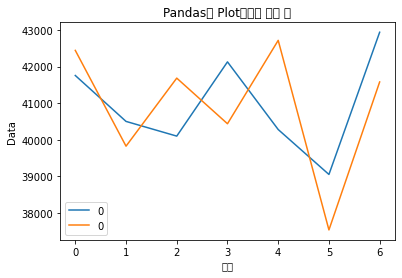

In [106]:
a_0=pd.DataFrame(actual_values_)[0:1][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[0:1][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

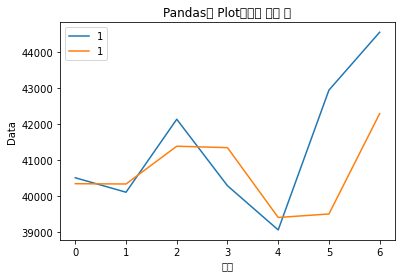

In [107]:
a_0=pd.DataFrame(actual_values_)[1:2][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[1:2][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

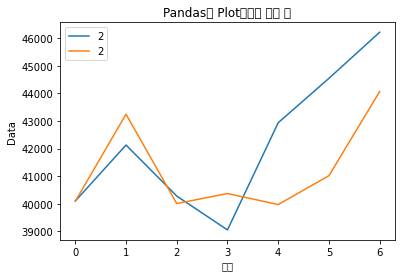

In [108]:
a_0=pd.DataFrame(actual_values_)[2:3][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[2:3][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

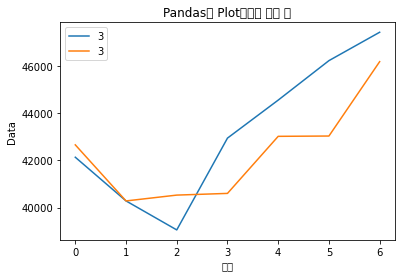

In [109]:
a_0=pd.DataFrame(actual_values_)[3:4][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[3:4][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

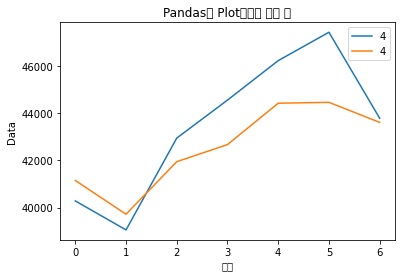

In [110]:
a_0=pd.DataFrame(actual_values_)[4:5][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[4:5][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

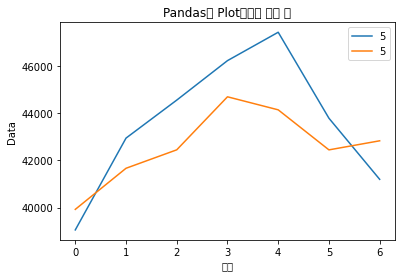

In [111]:
a_0=pd.DataFrame(actual_values_)[5:6][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[5:6][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

Text(0, 0.5, 'Data')

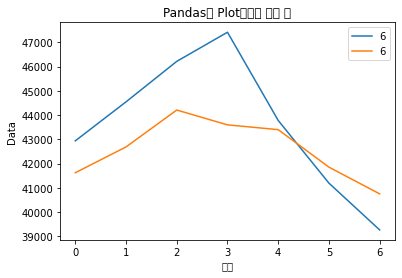

In [112]:
a_0=pd.DataFrame(actual_values_)[6:7][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[6:7][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

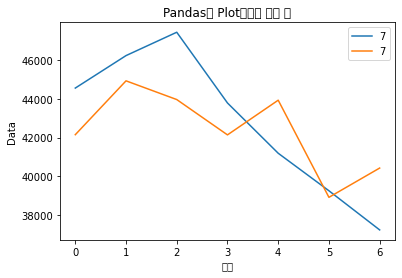

In [113]:
a_0=pd.DataFrame(actual_values_)[7:8][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[7:8][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

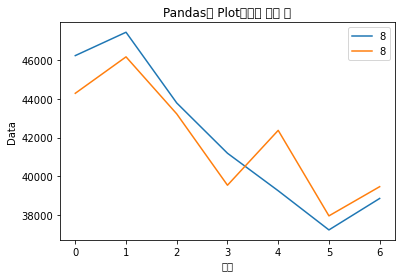

In [114]:
a_0=pd.DataFrame(actual_values_)[8:9][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[8:9][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

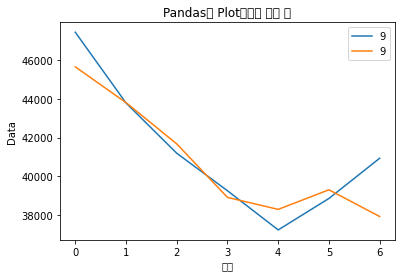

In [115]:
a_0=pd.DataFrame(actual_values_)[9:10][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[9:10][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

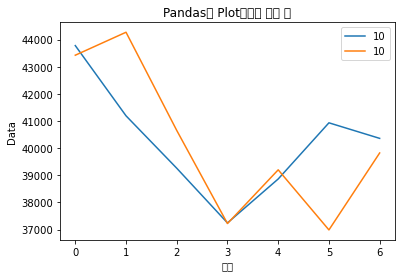

In [116]:
a_0=pd.DataFrame(actual_values_)[10:11][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[10:11][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

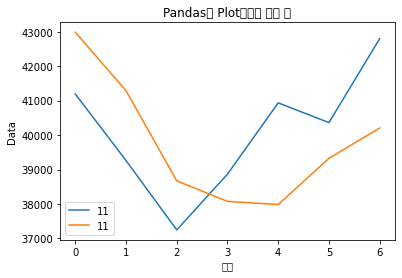

In [117]:
a_0=pd.DataFrame(actual_values_)[11:12][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[11:12][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

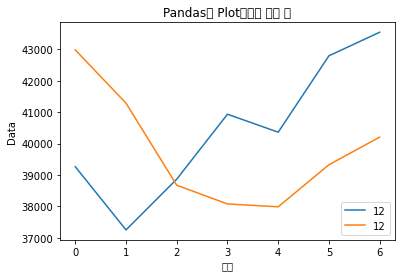

In [118]:
a_0=pd.DataFrame(actual_values_)[12:13][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[12:13][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")